In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.__version__, transformers.__version__, torch.version.cuda

('2.1.2+cu121', '4.39.0.dev0', '12.1')

In [3]:
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b"
# MODEL_PATH = "EleutherAI/pythia-2.8b-deduped"


mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
###################################################
prompt_template = mt.tokenizer.eos_token + " {} professionally played the sport of"

subject = "Michael Jordan"
alt_subject = "Pele"
###################################################

prompt = prompt_template.format(subject)


from src.functional import predict_next_token
predict_next_token(
    mt = mt,
    prompt = [
        prompt_template.format(subject) for subject in [subject, alt_subject]
    ]
)

[[PredictedToken(token=' basketball', prob=0.9139618873596191),
  PredictedToken(token=' Basketball', prob=0.02576393261551857),
  PredictedToken(token=' professional', prob=0.021030638366937637),
  PredictedToken(token='\n', prob=0.006415131501853466),
  PredictedToken(token=' baseball', prob=0.005233162082731724)],
 [PredictedToken(token=' soccer', prob=0.5141754150390625),
  PredictedToken(token=' football', prob=0.29559066891670227),
  PredictedToken(token=' association', prob=0.07368113100528717),
  PredictedToken(token=' Brazilian', prob=0.023992957547307014),
  PredictedToken(token=' professional', prob=0.0148796197026968)]]

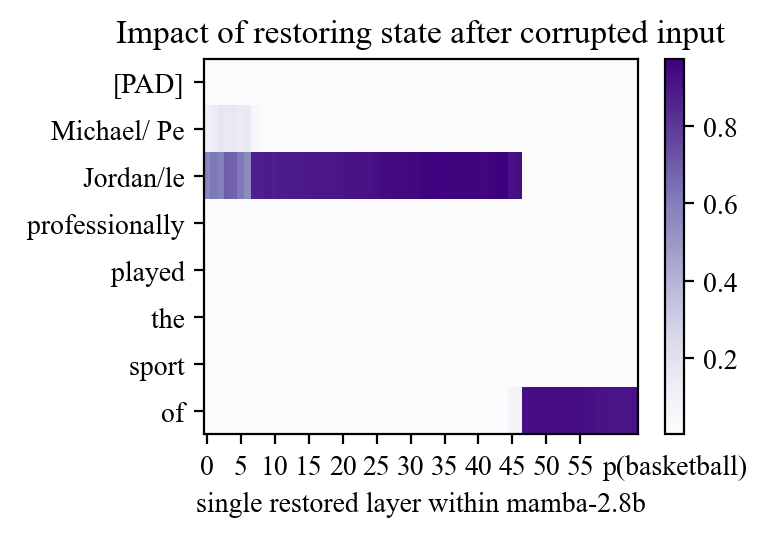

In [5]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap

indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt_template,
    subject = subject,
    alt_subject = alt_subject
    # subject = alt_subject,
    # alt_subject = subject
)
plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_ssm'


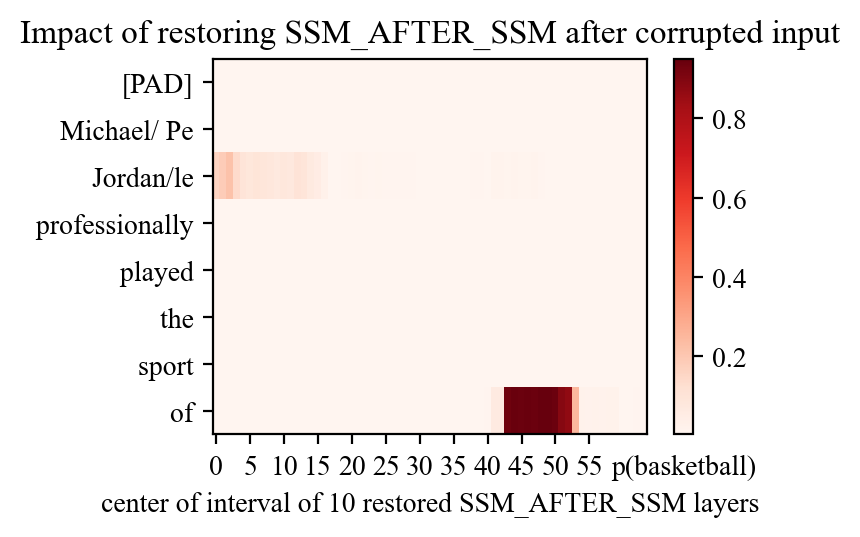

--------------------------------------------------------------------------------
mamba_block_hook='mlp_after_up_proj'


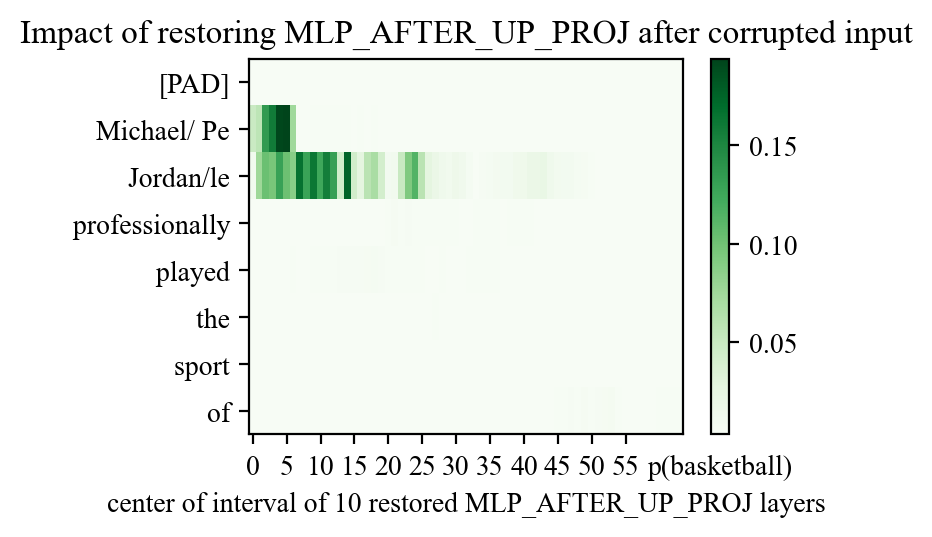

In [6]:
# for mamba_block_hook in get_args(MambaBlock_Hook_Points):
for mamba_block_hook in [
    "ssm_after_ssm", 
    "mlp_after_up_proj"
]:
    print("-"*80)
    print(f"{mamba_block_hook=}")
    mt.reset_forward()
    indirect_effects = calculate_hidden_flow(
        mt = mt,
        prompt = prompt_template,
        subject = subject,
        alt_subject = alt_subject,
        mamba_block_hook=mamba_block_hook
    )
    plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

In [7]:
# from src.tracing import calculate_hidden_flow
# from src.plotting import plot_trace_heatmap

# prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"

# subject = "The Space Needle"
# prompt = prompt_template.format(subject)

# indirect_effects = calculate_hidden_flow(
#     mt = mt,
#     prompt = prompt,
#     subject = subject,
# )
# plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

In [8]:
# from src.hooking.mamba import MambaBlock_Hook_Points
# from typing import get_args

# for mamba_block_hook in get_args(MambaBlock_Hook_Points):
#     print("-"*80)
#     print(f"{mamba_block_hook=}")
#     mt.reset_forward()
#     indirect_effects = calculate_hidden_flow(
#         mt = mt,
#         prompt = prompt,
#         subject = subject,
#         mamba_block_hook=mamba_block_hook
#     )
#     plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

In [9]:
# for kind in ["mlp", "attn"]:
#     print("-"*80)
#     print(f"{kind=}")
#     mt.reset_forward()
#     indirect_effects = calculate_hidden_flow(
#         mt = mt,
#         prompt = prompt,
#         subject = subject,
#         alt_subject=alt_subject,
#         kind=kind
#     )
#     plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])